In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp

# 1 Application

In [4]:
data = np.load('/home/kduplat/Documents/cours ML/TP_Filtrage/mydata_cluster.npz')

# Afficher les noms des tableaux stockés dans le fichier
print("Noms des tableaux dans le fichier :", data.files)

# Accéder à un tableau spécifique
tableau_psd = data['psd']
tableau_r = data['r']
tableau_y = data['y']
tableau_f = data['f']
print("Contenu du tableau :", tableau_psd)

# Fermer le fichier (optionnel mais recommandé pour de gros fichiers)
data.close()

Noms des tableaux dans le fichier : ['r', 'y', 'f', 'psd']
Contenu du tableau : [142.61281817 142.61281817  67.06471569  43.29306749  31.82027966
  25.11212913  20.73041364  17.65308587  15.37816886  13.63094387
  12.24870599  11.12909424  10.20456343   9.4287831    8.76893927
   8.20115536   7.70765295   7.27492807   6.89254367   6.5523087
   6.2477069    5.97349106   5.72538955   5.4998905    5.29408068
   5.10552363   4.93216635   4.77226701   4.62433832   4.48710294
   4.35945776   4.24044536   4.12923075   4.02508256   3.92735746
   3.83548737   3.74896883   3.66735407   3.5902436    3.51727984
   3.44814183   3.38254067   3.32021562   3.26093077   3.20447217
   3.15064536   3.09927315   3.05019383   3.00325947   2.95833451
   2.9152945    2.87402496   2.83442047   2.79638371   2.75982478
   2.72466046   2.69081361   2.65821265   2.62679104   2.59648688
   2.56724246   2.53900399   2.51172121   2.48534713   2.45983776
   2.43515191   2.41125091   2.38809849   2.36566054   2.343904

In [5]:
# Colored noise

def generate_gaussian_data(n, a, b):
    return np.random.normal(loc=a, scale=b, size=n)

def generate_col_noise(TPSD):
    bbg = generate_gaussian_data(len(TPSD), 0, 0.001)
    TF_bbg = np.fft.fft(bbg) 
    TF_bbg_bis = TF_bbg * np.sqrt(TPSD)
    TF_inv_bbg = np.fft.ifft(TF_bbg_bis)
    
    return TF_inv_bbg.real

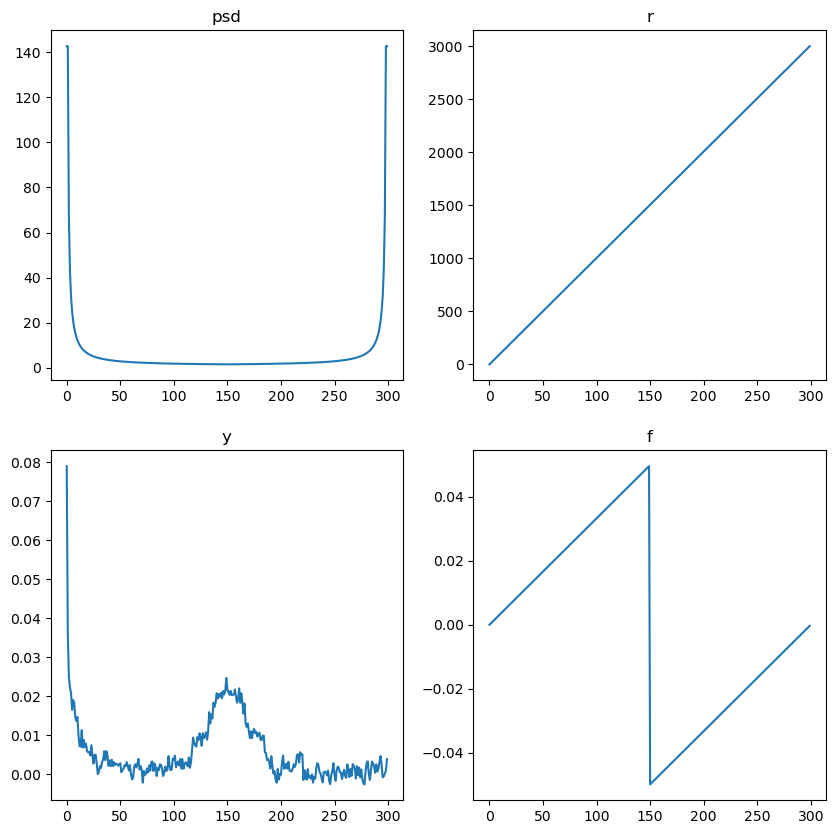

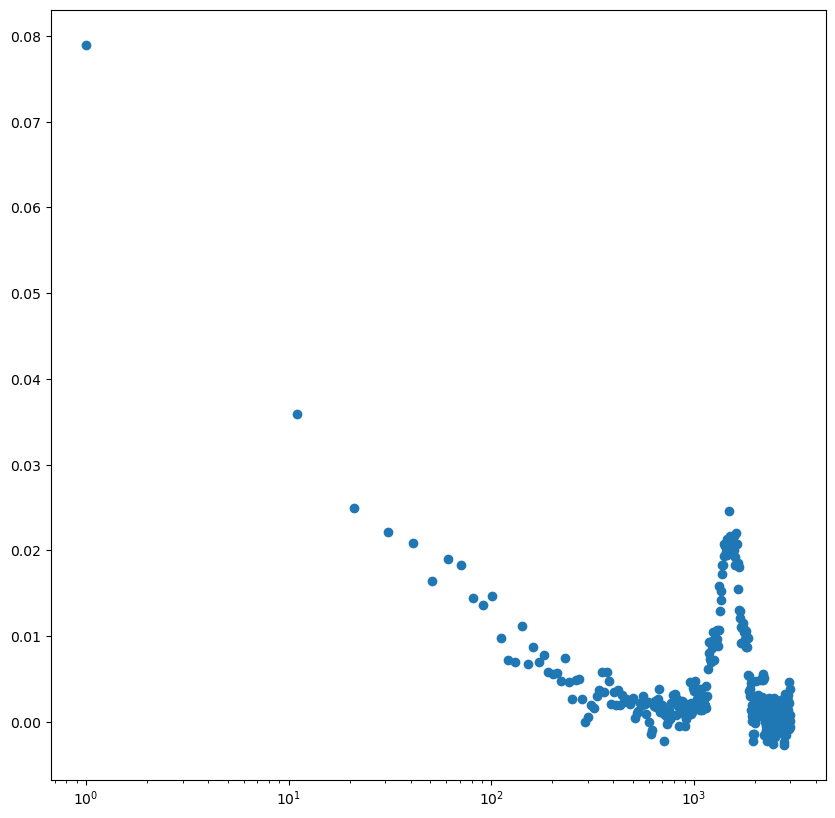

In [6]:
plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
plt.plot(tableau_psd)
plt.title('psd')
plt.subplot(2,2,2)

plt.plot(tableau_r)
plt.title('r')
plt.subplot(2,2,3)

plt.plot(tableau_y)
plt.title('y')
plt.subplot(2,2,4)
plt.plot(tableau_f)
plt.title('f')
plt.show()

plt.figure(figsize=(10, 10))
plt.scatter(tableau_r, tableau_y)
plt.xscale('log')
plt.show()

## Noise generation

In [7]:
from numpy.linalg import inv

Cov = 0

nb_real = 10000
for i in range (nb_real):
    col_noise = generate_col_noise(tableau_psd)
    Cov += np.outer(col_noise.T, col_noise)
    
Cov = Cov/nb_real
Inv_Cov = inv(Cov)

In [8]:
a = 1.1
b = 5.5
c = 0.31


In [9]:
def gaussfct(x,A,x0,sigma):
    return A * np.exp(-(x - x0)**2/(2 * sigma**2))

def fct_densité(r, rp, rho_z, A, mu, sigma):
    
    gauss = gaussfct(r, A, mu, sigma)
    rho_r = rho_z/((r/rp)**c * (1 + (r/rp)**a)**((b-c)/a))
    return rho_r + gauss





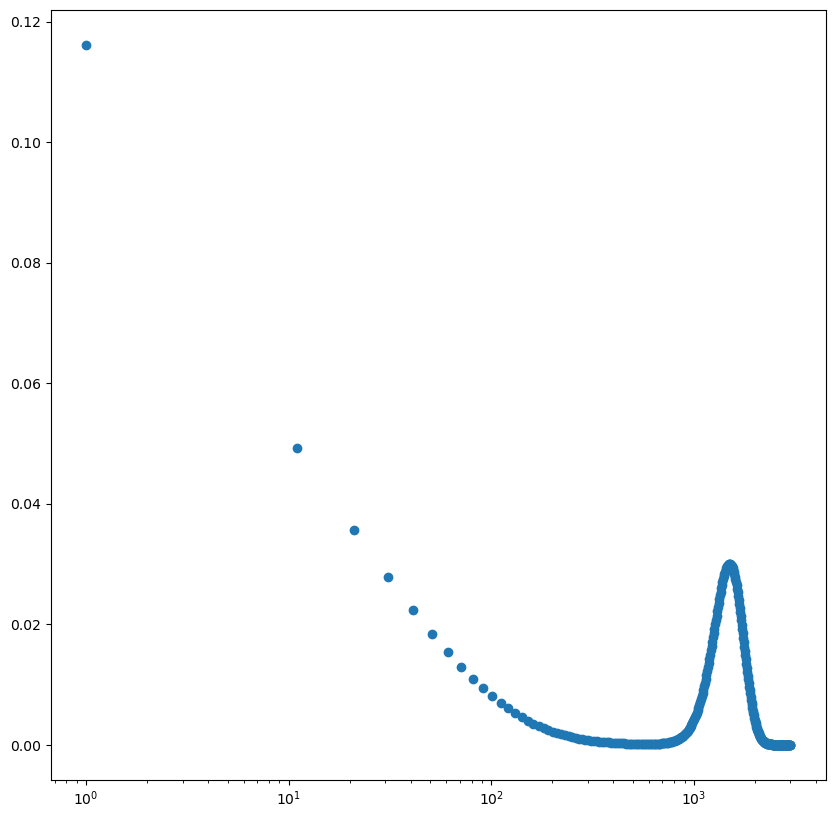

In [10]:
A = 0.03
mu = 1500
sigma = 250
rho_z = 0.02
rp = 300

params = [rp, rho_z, A, mu, sigma]
gaus_data = gaussfct(tableau_r, A, mu, sigma)

signal = fct_densité(tableau_r, rp, rho_z, A, mu, sigma)

plt.figure(figsize=(10, 10))
plt.scatter(tableau_r, signal)
plt.xscale('log')
plt.show()

rp = 901.106775343156, rho_z = 0.00939843995629463, A= 0.02110645881399912, mu= 1518.1927631585731, sigma= 204.88530355904697


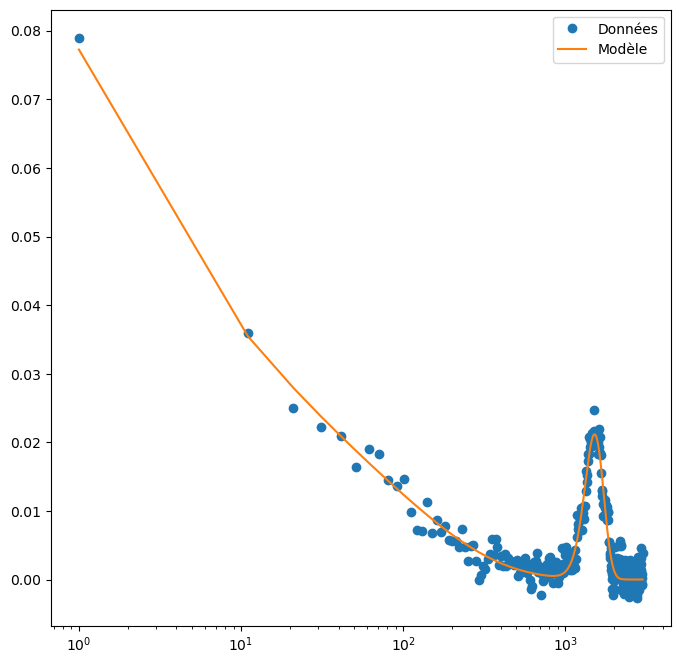

In [11]:
from scipy.optimize import curve_fit

popt, pcov = curve_fit(fct_densité, tableau_r,tableau_y, p0 = params)

rp_fit, rho_zfit, A_fit, mu_fit, sigma_fit = popt
print("rp = {}, rho_z = {}, A= {}, mu= {}, sigma= {}".format(rp_fit, rho_zfit, A_fit, mu_fit, sigma_fit))

y_fit = fct_densité(tableau_r, rp_fit, rho_zfit, A_fit, mu_fit, sigma_fit)
plt.figure(figsize=(8, 8))
plt.plot(tableau_r, tableau_y, 'o', label='Données')
plt.plot(tableau_r, y_fit, label='Modèle')
plt.xscale('log')
plt.legend()
plt.show()



In [12]:
from scipy.stats import chisquare


#### Marche pas car pour la loi de poisson
y_fit_normalized = y_fit * (sum(tableau_y) / sum(y_fit))

chi2 = chisquare(f_obs=tableau_y, f_exp=y_fit_normalized)

print(f"Chi2 statistic: {chi2.statistic}, p-value: {chi2.pvalue}")


chi2_2 = np.sum((tableau_y - y_fit)**2 / y_fit)

print ("Chi2 manual = ", chi2_2)
#### Marche pas car pour la loi de poisson

# CHI2 attendu

Chi2_mat = np.dot((tableau_y - y_fit).T, np.dot(Inv_Cov, (tableau_y - y_fit)))

print("Chi2 attendu = {} +/- {}".format(Chi2_mat, np.sqrt(2*295)))

# On s'attend àn avoir un Chi2 qui est égale à 300 - 5 (Nb de point - nb de degré de liberté)


Chi2 statistic: 34.248511756295606, p-value: 1.0
Chi2 manual =  36.48597771881528
Chi2 attendu = 266.71332457359927 +/- 24.289915602982237


In [13]:

#Tirage de 1000 valeurs selon la loi normale multivariée avec les para trouvé précédemment

vals = np.random.multivariate_normal(popt, pcov, 1000)


print(vals)

[[9.45469143e+02 8.80883515e-03 2.08961640e-02 1.51949591e+03
  1.94300827e+02]
 [9.38604097e+02 9.24356133e-03 2.13537155e-02 1.52705679e+03
  2.08547711e+02]
 [8.87114170e+02 9.60671845e-03 2.07603019e-02 1.51982041e+03
  2.13088548e+02]
 ...
 [8.57104022e+02 9.50428159e-03 2.06600151e-02 1.52660109e+03
  2.12540538e+02]
 [9.09742589e+02 9.18946814e-03 2.09125616e-02 1.51470970e+03
  2.08893723e+02]
 [9.32163896e+02 9.48684922e-03 2.12660067e-02 1.51081679e+03
  2.06025693e+02]]


In [14]:
from getdist import MCSamples, plots


names = ["rp", "rho_z", "A", "mu", "sigma"]
labels = ["rp", "rho_z", "A", "mu", "sigma"]

#On regarde notre intervale de confiance sur les paramètres

mcsamples = MCSamples(samples=vals, names=names, labels=labels)
mcsamples2 = MCSamples(samples=np.random.multivariate_normal(popt, pcov, 1000), names=names, labels=labels)


Removed no burn in
Removed no burn in


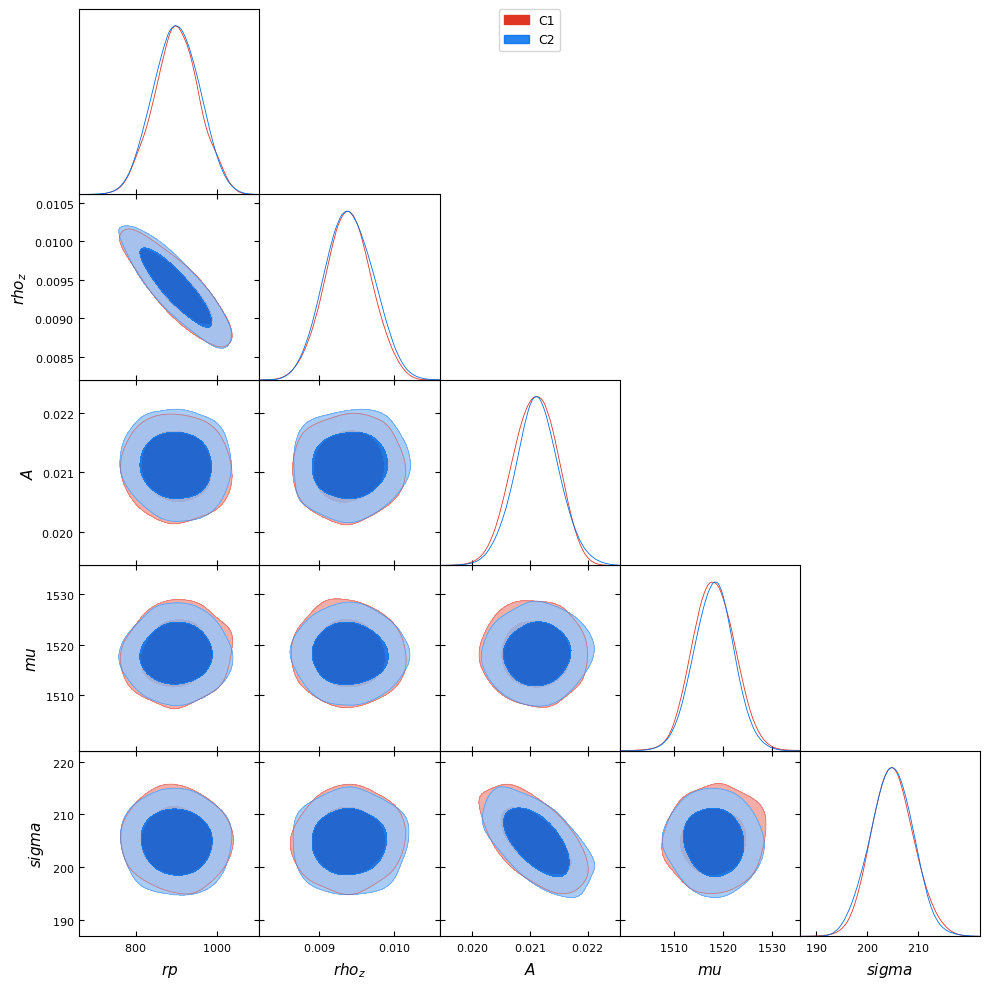

In [15]:
g = plots.get_subplot_plotter()

g.triangle_plot([mcsamples, mcsamples2], filled=True, legend_labels=["C1", "C2"])


# 1.2 MCMC

In [ ]:
def generate_gaussian_data(a, b, n):
    return np.random.normal(loc=a, scale=b, size=n)


#Tirage gaussien des paramètre tetap en fonction de teta et dteta
def params_def(teta, dteta):
    return np.random.normal(teta, dteta)


In [17]:
#Exemple pour verifier que ça marche

teta = [1,2,4,6,12]
dteta = [0.1,0.1,0.1,0.1,0.1]
teta_p = params_def(teta, dteta)

print(teta_p)


[ 0.78356817  1.77160079  4.02297277  5.95841964 12.02552966]


In [ ]:
#rp = 901.106775343156, rho_z = 0.00939843995629463, A= 0.02110645881399912, mu= 1518.1927631585731, sigma= 204.88530355904697

#Condions initiales sur nos paramètres
def log_prior(params):
    rp, rho_z, A, mu, sigma = params
    if 0<rp and  0<rho_z  and 0 < A <0.05 and 0 < mu  and 0 < sigma :
        return 0
    else:
        print("-inf log prior")
        print("rp = {}\nrho_z = {}\nA= {}\nmu= {}\nsigma= {}".format(rp, rho_z, A, mu, sigma))
        return -np.inf


#Fonction de vraisemblance pour not fct_densité
def log_likelihood(params):
    
    Vraisemblance = fct_densité(tableau_r, *params)
    
    Chi2 = np.dot((tableau_y - Vraisemblance).T, np.dot(Inv_Cov, (tableau_y - Vraisemblance)))
    
    return (-1/2 * Chi2)

#log(a) dans le cours diapo 24
def log_acceptance(teta, teta_p):
    return log_likelihood(teta_p) + log_prior(teta_p) - log_likelihood(teta) - log_prior(teta)


#On verifie que le tirage se rapproche de la vrai valeur 
def test_acceptance(teta, teta_p):
    if log_acceptance(teta, teta_p) >= np.log(np.random.uniform()):
        return teta_p
    else:
        return teta
    
#Algo de la diapo 24
def Metropolis_Hastings(teta_0, n_iter):
    #Init val
    teta = teta_0
    teta_list = [teta]
    #Algo
    for _ in range(n_iter):
        dteta_0 = np.array(teta) * 0.075 
        teta_p = params_def(teta, dteta_0)
        teta = test_acceptance(teta, teta_p)
        teta_list.append(teta)
    return teta_list

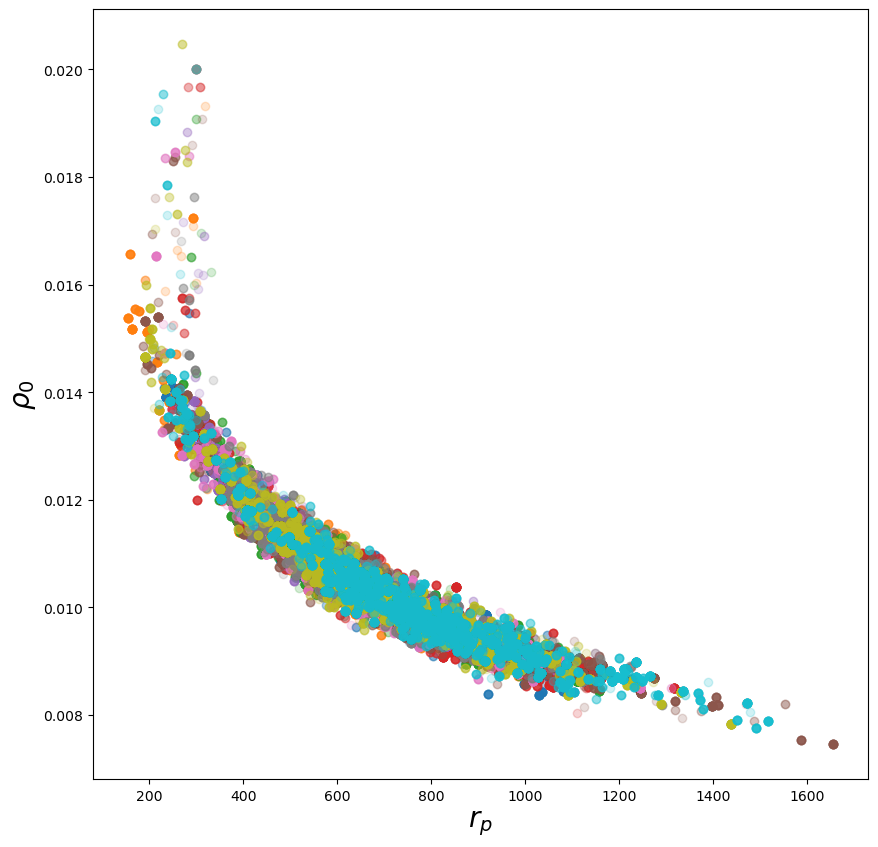

In [100]:
A = 0.03
mu = 1500
sigma = 250
rho_z = 0.02
rp = 300

teta_0 = [rp, rho_z, A, mu, sigma]
n_iter = 10000

n_Markov = 10

full_teta_list = np.zeros((n_Markov, n_iter+1, len(teta_0)))

plt.figure(figsize=(10, 10))
for i in range(n_Markov):
    
    teta_list = Metropolis_Hastings(teta_0, n_iter)
    teta_list_np = np.array(teta_list)
    full_teta_list[i] = teta_list_np
    plt.scatter(teta_list_np[:,0], teta_list_np[:,1], alpha = 0.2)
    
plt.xlabel(r'$r_p$', fontsize = 20)
plt.ylabel(r'$\rho _0$', fontsize = 20)
plt.show()

In [101]:
# print(teta_list)

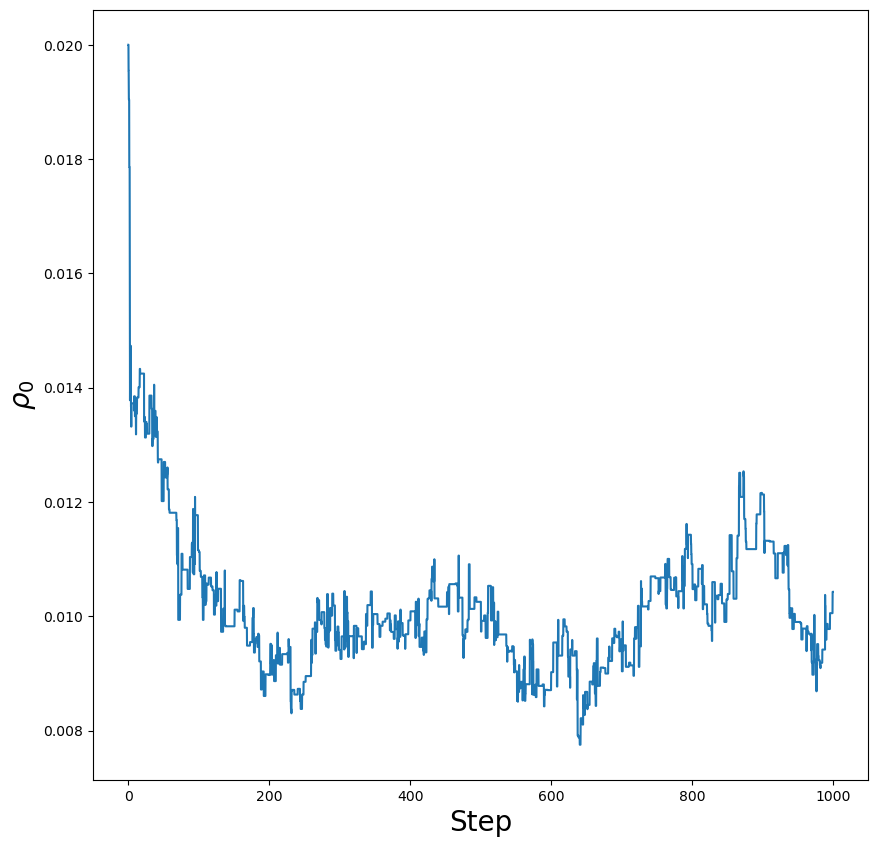

In [102]:
teta_list_np = np.array(teta_list)

x = np.arange(0, len(teta_list_np)/10, 0.1)
plt.figure(figsize=(10, 10))
plt.plot(x, teta_list_np[:,1])
plt.xlabel(r'Step', fontsize = 20)
plt.ylabel(r'$\rho _0$', fontsize = 20)
plt.show()



/tmp/ipykernel_9074/2336531786.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('inferno')


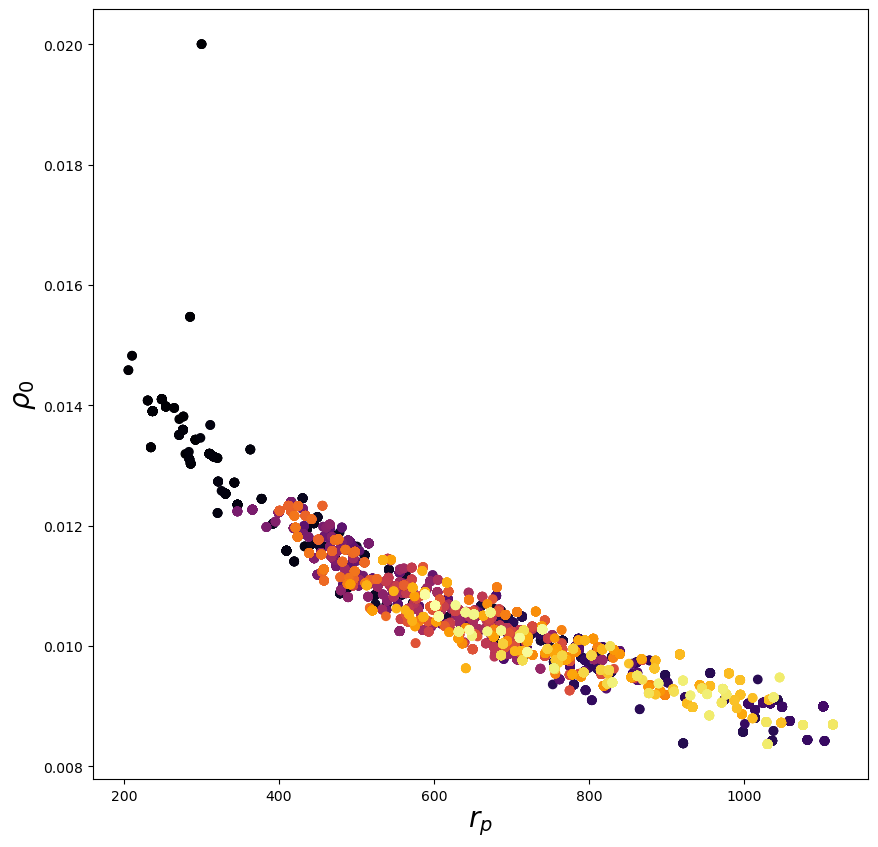

In [103]:
NCURVES = len(teta_list_np)
cmap = plt.cm.get_cmap('inferno')
colors = [cmap(i / NCURVES) for i in range(NCURVES)]

plt.figure(figsize=(10, 10))
plt.scatter(full_teta_list[0,:,0], full_teta_list[0,:,1], color = colors)
plt.xlabel(r'$r_p$', fontsize = 20)
plt.ylabel(r'$\rho _0$', fontsize = 20)
plt.show()

#   1.3 librairie emcee

In [108]:
def log_probability(params): # log de la loi de probabilité (P(teta| d) = L(d|teta) * pi(teta))
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return log_likelihood(params) + log_prior(params)
    
    
    

[[2.85632476e+02 2.04407724e-02 2.87453563e-02 1.43269350e+03
  2.45510439e+02]
 [2.44395203e+02 1.84076233e-02 3.32492632e-02 1.65199046e+03
  2.30454753e+02]
 [3.56335417e+02 2.22773092e-02 2.56147458e-02 1.45360146e+03
  2.81399274e+02]
 [2.52554593e+02 1.64461774e-02 3.33698469e-02 1.55578011e+03
  2.18540277e+02]
 [2.74206792e+02 1.53860308e-02 3.26473958e-02 1.51058358e+03
  2.44261929e+02]
 [3.17216162e+02 2.12549835e-02 3.08932082e-02 1.70638205e+03
  2.64367010e+02]
 [3.09107669e+02 1.99627459e-02 3.23114223e-02 1.53633908e+03
  2.34143733e+02]
 [2.72578768e+02 1.96848866e-02 2.90131818e-02 1.69523247e+03
  2.57441541e+02]
 [3.07161598e+02 2.19302833e-02 2.46956516e-02 1.24730689e+03
  2.52116578e+02]
 [3.26049224e+02 1.78217591e-02 3.04910274e-02 1.52280937e+03
  2.04618893e+02]]
-inf log prior
rp = -383.58567445873086
rho_z = 0.016957596239760214
A= 0.03278443409626495
mu= 1561.9555179330664
sigma= 261.9877475043528
-inf log prior
rp = -29.152418728743896
rho_z = 0.014860650

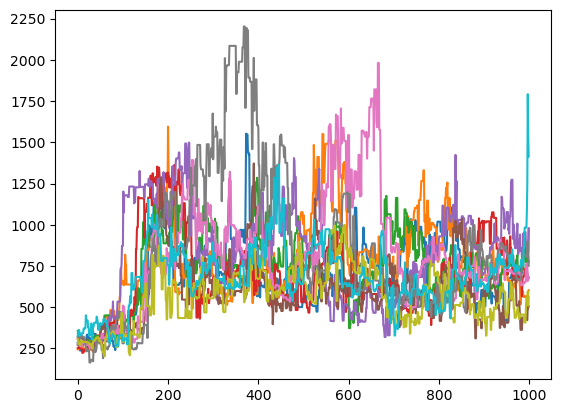

In [110]:
import emcee
ndim = len(teta_0)
nwalkers = 10
nstep = 1000
p0 = np.zeros((nwalkers, ndim))

A = 0.03
mu = 1500
sigma = 250
rho_z = 0.02
rp = 300
teta_0 = [rp, rho_z, A, mu, sigma]

dteta_0 = np.array(teta_0) * 0.1
# dteta_0 = [10, 0.0001, 0.001, 10, 1]

for i in range(nwalkers):
    p0[i] = params_def(teta_0, dteta_0)

print(p0)
    
# p0 = np.random.rand(nwalkers, ndim)

# print(p0)
# print(p0.shape)


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

sampler.run_mcmc(p0, nstep)

chains = sampler.get_chain()
plt.plot(chains[:, :, 0])

In [ ]:
def Gelman_rubin(Tab_chaine):
    """
    Tab_chaine : array de forme (N, M), où N est la longueur des chaînes et M est le nombre de chaînes.
    """
    N = Tab_chaine.shape[1] 
    M = Tab_chaine.shape[0] 
    mean_chaine = np.mean(Tab_chaine, axis=1)
    meanTab = np.mean(Tab_chaine)

    B = np.sum((mean_chaine - meanTab)**2) / (M - 1)
    W = np.mean(np.var(Tab_chaine, axis=0, ddof=1))

    # Estimation de la variance postulée
    Var_post = (1 - 1/N) * W + (1+1/M) * B

    # Calcul du facteur Gelman-Rubin
    R = Var_post / W
    
    return R

    
    

In [ ]:
for i in range(len(teta_0)):
    print("GR of {} = {}".format(names[i], Gelman_rubin(full_teta_list[:, 20:, i])))

GR of rp = 1.1838344442511448
GR of rho_z = 1.1750424803285677
GR of A = 1.0219782444369796
GR of mu = 1.0038893630678336
GR of sigma = 1.0149589901272669


In [ ]:
A = 0.03
mu = 1500
sigma = 250
rho_z = 0.02
rp = 300

teta_0 = [rp, rho_z, A, mu, sigma]
n_iter = 5000

n_Markov = 10

# full_teta_list = np.zeros((n_Markov, n_iter+1, len(teta_0)))

R=100

while(R > 1.03):
    n_iter *= 2
    full_teta_list = np.zeros((n_Markov, n_iter+1, len(teta_0)))
    
    for i in range(n_Markov):
    
    
        teta_list = Metropolis_Hastings(teta_0, n_iter)
        teta_list_np = np.array(teta_list)
        full_teta_list[i] = teta_list_np
        
    R = Gelman_rubin(full_teta_list[:, int(n_iter * 0.1):, 0])
    print("Gelman_rubin of {} = {}".format(names[0], Gelman_rubin(full_teta_list[:, int(n_iter * 0.1):, 0])))
        
print(n_iter)
        


Gelman_rubin of rp = 1.0881661495174701
Gelman_rubin of rp = 1.0745663957699751
Gelman_rubin of rp = 1.012284821254764
40000
